# Emotion Classification of Video Clips
### Stuart Neilson, Malvika Menon, Jeff Winchell, Michelle Xie $\bullet$ Harvard University CS109B Final Project 2019
(Group 1)

## Problem Statement

For this project our group would like to classify the emotions of the human face from a dataset of short video files as accurately as possible.

## Data Resources

We will be using the BAUM-1 dataset (Bahcesehir University Multimodal Face Database of Spontaneous Affective and Mental States), a sample that includes 1500 video clips from 31 subjects who show an unscripted variety of both emotional and mental states in Turkish. Based on stimuli presented, synchronous facial recordings were recorded to classify eight emotions (happiness, anger, sadness, disgust, fear, surprise, boredom, and contempt) and certain mental states (unsureness, thoughtfulness, concentration, interest, bothered). 

We chose this dataset because 1) it provides a relevant challenge that will utilize the skills learned in this class, 2) is a manageable size, and 3) has a rich variety of data, in some ways more powerful than comparable datasets only recording the six basic emotions, lending possibly more novel predictive power. (Link to data description: http://mimoza.marmara.edu.tr/~cigdem.erdem/BAUM1/)

## Strategy & Overview

First, we explore the data set and select for certain emotions, making other adjustments along the way that will be described. After loading and processing the data, we then construct three models in the interest of finding the most accurate means of classifying emotions:

1. Conv3d
2. TimeDistributed Conv2d plus RNN
3. "DeepFace" based on vgg_face_weights

There were many interesting considerations and modifications necessitated along the way including: selection of frames, scaling of data, tweaking of model hyperparameters, etc. We will present the results from these three models and discuss their outcomes as well as other avenues we could have taken in terms of strategy and execution. In the end, we found that the Model 1 correctly predicted 42 emotions (29% of the 144 test videos) and that Model 2 correctly predicted 44 (31%). Lastly, Model 3 always classified inputs as one emotion, an issue we could not overcome sufficiently and will further discuss. With these myriad results, we found relative success in the first two models, and the opposite in the third model, a lesson learnt that will be further detailed. 

## Literature Review & Model Selection Motivation

Videos for emotional classification purposes have been shown to have a unique level of power of prediction, looking at properties like feature-point tracking and texture-based features that can be utilized to train classifiers (Bargal et al. 16). While a snapshot is an important indicator of emotion, the dynamism of the sequence of frames, often supplemented by tonal features of audio components, make videos a powerful yet complicated data set for the purposes of emotional classification. We were inspired by the EmotiW challenge, which looks at real world issues that can be solved with affective computing, with the goal being to benchmark algorithms on ‘in the wild’ data. There are two aspects of our dataset that will be pertinent for this literature review 1) emotional classification strategies and models 2) video analysis. 

Conventionally, unsupervised learning methods seem to perform less well for this purpose. However, “Emotional classification of Youtube videos” utilizes an ensemble model of both supervised and unsupervised learning methods to classify emotions from Youtube videos with relative success (Chen 17), indicating that such creative strategies might be worth testing in our case. Additionally, an EmotiW Challenge 2016 contender paper also deems that based on reality TV videos, CNN and LSTM-RNN are comparable methods with regards to accuracy (Ding et al. 16). Indeed, based on our exploration, we attempt to use hybridized model structures, as they have been shown to be effective for projects in emotional classification. Conv3d models have been established to be helpful in video analysis, and the incorporation of RNN's has only improved such performance (Fan et al. 16). This research motivates the selection of the first two model structures.  A further examination also indicated that the utilization of VGGFace NN and pretrained weights might make our endeavors in this project more streamlined, motivating our third model's selection. (Rassadin et al 17)

### 0. Packages

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pylab
import imageio
import cv2
import keras
from keras.utils import to_categorical
import random
import zipfile
import os
import shutil
from keras import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv3D,MaxPooling3D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout, Activation, InputLayer
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.models import model_from_json
from collections import Counter
import xml.etree.ElementTree as ET

Using TensorFlow backend.


### 1. EDA

#### a. Examining the Acted Video Dataset

In [2]:
# read excel of attributes in
dfacted = pd.read_excel('./BAUM/acted/Annotations_BAUM1a.xlsx')
# check for null values
dfacted.isnull().values.any()
# Unnamed columns seem to delineate null values
dfacted.isnull().sum()

Number             0
Subject Label      0
Clip               0
Clip Name          0
Emotion            0
Emotion Code       0
Gender             0
Unnamed: 7       265
Unnamed: 8       255
Unnamed: 9       256
Unnamed: 10      254
dtype: int64

In [3]:
# Preview data
dfacted.head()

,Number,Subject Label,Clip,Clip Name,Emotion,Emotion Code,Gender,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,1,1,1,S001_001,Anger,1,M,NaN,Emotion Codes,NaN,Total Count
1,2,1,2,S001_002,Disgust,3,M,NaN,1,Anger,43
2,3,1,3,S001_003,Boredom,2,M,NaN,2,Boredom,27
3,4,1,4,S001_004,Intrest,6,M,NaN,3,Disgust,35
4,5,2,2,S002_002,Happiness,5,M,NaN,4,Fear,36


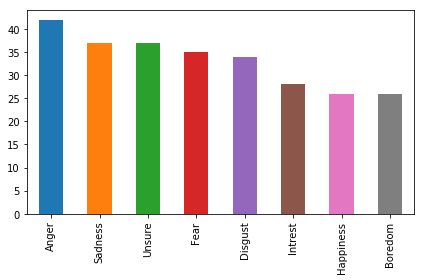

In [4]:
# Look at frequencies of emotions based on stimuli
dfacted['Emotion'].value_counts().plot('bar')
plt.tight_layout()
plt.savefig("figure.png")

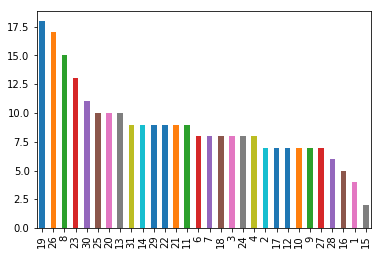

In [5]:
# Look at distribution of subjects
dfacted['Subject Label'].value_counts().plot('bar')

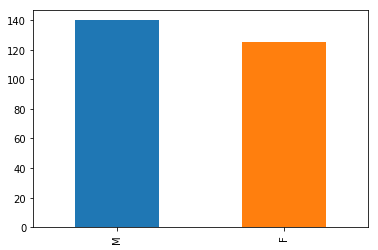

In [6]:
# Map sample distribution of gender
dfacted['Gender'].value_counts().plot('bar')

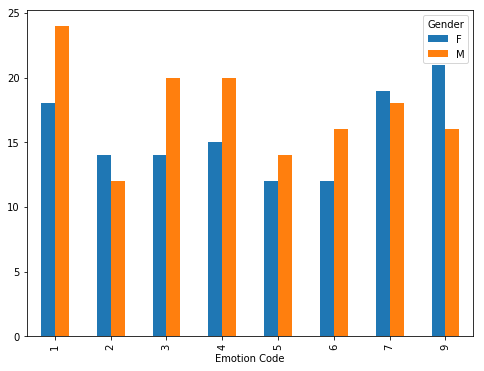

In [7]:
# Looking at whether certain genders are more likely to be classified for different emotional categories
dfacted.groupby(['Emotion Code', 'Gender'] )['Gender'].count().unstack(1).plot.bar(figsize=(8, 6))

#### b. Examining the Spontaneous Video Dataset

In [8]:
# read excel of attributes in
dfnonacted = pd.read_excel('./BAUM/Spontaneous/Annotations_BAUM1s.xlsx')
# check for null values
dfnonacted.isnull().values.any()
# Unnamed columns seem to delineate null values
dfnonacted.isnull().sum()

Number                                 0
Subject Label                          0
Clip                                   0
Clip Name                              0
Emotion                                0
Emotion Code                           0
Gender                                 0
Age                                    0
Frame number for apex expression    1134
Unnamed: 9                          1134
Unnamed: 10                         1120
Unnamed: 11                         1120
Unnamed: 12                         1119
dtype: int64

In [9]:
dfnonacted.head()

,Number,Subject Label,Clip,Clip Name,Emotion,Emotion Code,Gender,Age,Frame number for apex expression,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,1,5,S001_005,Unsure,13,M,23,NaN,NaN,Emotion Codes,NaN,Total Count
1,2,1,6,S001_006,Thinking,12,M,23,NaN,NaN,1,Anger,59
2,3,1,7,S001_007,Concentrating,4,M,23,NaN,NaN,2,Boredom,22
3,4,1,8,S001_008,Concentrating,4,M,23,NaN,NaN,3,Bothered,91
4,5,1,9,S001_009,Unsure,13,M,23,NaN,NaN,4,Concentrating,64


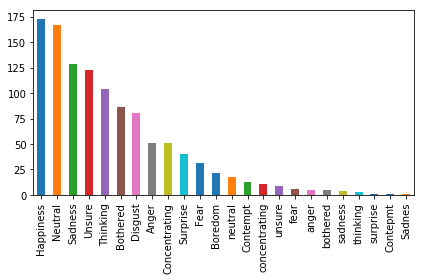

In [10]:
# Look at frequencies of emotions based on stimuli
dfnonacted['Emotion'].value_counts().plot('bar')
plt.tight_layout()
plt.savefig("figure.png")

Note that that the distribution of emotions is less equal when thes videos are spontaneous.

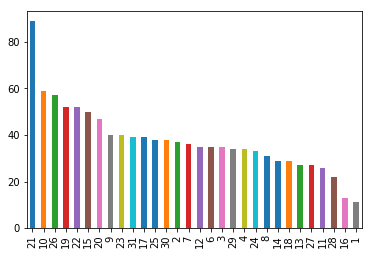

In [11]:
# Look at distribution of subjects
dfnonacted['Subject Label'].value_counts().plot('bar')

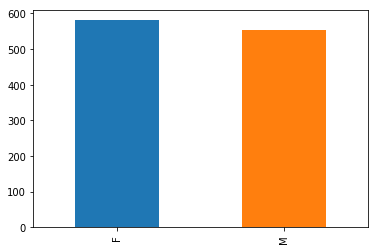

In [12]:
# Map sample distribution of gender
dfnonacted['Gender'].value_counts().plot('bar')

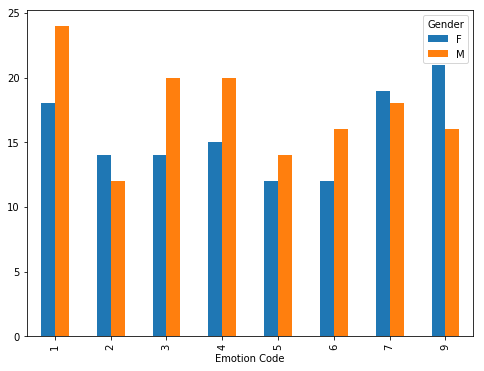

In [13]:
# Looking at whether certain genders are more likely to be classified for different emotional categories
dfacted.groupby(['Emotion Code', 'Gender'] )['Gender'].count().unstack(1).plot.bar(figsize=(8, 6))

### Note that both of these subsets of the whole dataset of videos offer differential distributions and likely offer varied conclusions when utilized to train for classifications.

#### c. Looking at a possible supplemental data set (EmotiW 2019 Audio-Video Emotion Recognition)

In [14]:
#tree = ET.parse("Train/Train_6.xml")
#root = tree.getroot()
#
#get_range = lambda col: range(len(col))
#l = [{r[i].tag:r[i].text for i in get_range(r)} for r in root]
#
#EmotiW_df = pd.DataFrame.from_dict(l)
#EmotiW_df.to_csv('file.csv')

In [15]:
#EmotiW_df = pd.read_csv('file.csv')

#EmotiW_df.head()

#### d. Data Cleaning and Adjustment Decisions based on Data Exploration

We are more interested in the spontaneous dataset as this more so mirrors an "in the wild" dataset and should allow more versatile tests of classification. Classification data will thus be derived from the "Emotion Code" file from the Annotations CSV explored above in part (a).  "Neutral" and "Unsure" videos are removed for the sake of cleaner classification and clarity. Moreover, we remove the relast common emotions of "Boredom", "Contempt" and "Fear."  Each remaining emotion is represented by at least 40 videos. Lastly, the data is balanced  with weighted sampling by the generator.

### 2. Data Processing

In [16]:
# read excel of attributes in
df_a = pd.read_excel('./BAUM/acted/Annotations_BAUM1a.xlsx').loc[:,['Number','Subject Label','Clip','Clip Name','Emotion','Emotion Code','Gender']]
df_s = pd.read_excel('./BAUM/Spontaneous/Annotations_BAUM1s.xlsx').loc[:,['Number','Subject Label','Clip','Clip Name','Emotion','Emotion Code','Gender','Age']]

# remove Neutral/Unsure coded vides
df_a = df_a[df_a['Emotion Code'] != 9]
df_s = df_s[df_s['Emotion Code'] != 9]
df_s = df_s[df_s['Emotion Code'] != 13]

# remove other categories that are infrequent, to have a more balanced sample 
df_s = df_s[df_s['Emotion Code'] != 2]
df_s = df_s[df_s['Emotion Code'] != 5]
df_s = df_s[df_s['Emotion Code'] != 7]

df = pd.concat([df_a,df_s],sort=False)

Emotion Codes in the Spontaneous Videos:

1.	Anger
2.	Boredom
3.	Bothered
4.	Concentrating
5.	Contempt
6.	Disgust
7.	Fear
8.	Happiness
9.	Neutral
10.	Sadness
11.	Surprise
12.	Thinking
13.	Unsure 

Emotion Codes in the Acted Videos:

1.	Anger
2.	Boredom
3.	Disgust
4.	Fear
5.	Happiness
6.	Interest
7.	Sadness
8.	Surprise
9.	Unsure

In [17]:
# look at emotion counts in the acted data set
df_a['Emotion Code'].value_counts()

1    42
7    37
4    35
3    34
6    28
5    26
2    26
Name: Emotion Code, dtype: int64

In [18]:
# look at emotion counts in the spontaneous data set
df_s['Emotion Code'].value_counts()

8     172
10    134
12    107
3      91
6      80
4      62
1      56
11     41
Name: Emotion Code, dtype: int64

In [19]:
# examine data set shapes
print(df_a.shape)
print(df_s.shape)
print(df.shape)

(228, 7)
(743, 8)
(971, 8)


In [20]:
# preview annotations data
df.head()

,Number,Subject Label,Clip,Clip Name,Emotion,Emotion Code,Gender,Age
0,1,1,1,S001_001,Anger,1,M,NaN
1,2,1,2,S001_002,Disgust,3,M,NaN
2,3,1,3,S001_003,Boredom,2,M,NaN
3,4,1,4,S001_004,Intrest,6,M,NaN
4,5,2,2,S002_002,Happiness,5,M,NaN


In [21]:
caps = []
caps_a = []
caps_s = []

s_list_a = []
f_list_a = []
s_list_s = []
f_list_s = []


# Delineating acted videos and names
for i in range(len(df_a)):
    s = "s" + "%03d" % (df_a['Subject Label'].iloc[i])
    f = df_a['Clip Name'].iloc[i]
    file = './BAUM/acted/' + s + '/' + f + '.mp4'
    #label = df_a['Emotion Code'].iloc[i]
    caps_a.append(file)
    s_list_a.append(s)
    f_list_a.append(f)

# Delineating spontaneous videos and names
for i in range(len(df_s)):
    s = "s" + "%03d" % (df_s['Subject Label'].iloc[i])
    f = df_s['Clip Name'].iloc[i]
    file = './BAUM/Spontaneous/' + s + '/' + f + '.mp4'
    #label = df_s['Emotion Code'].iloc[i]
    caps_s.append(file)
    s_list_s.append(s)
    f_list_s.append(f)
    
caps = caps_a + caps_s

# find total number of videos
print("Number of videos: ",len(caps))

Number of videos:  971


In [22]:
# selecting videos and distribution accordingly
np.random.seed(1234567890)
selector_s = np.random.uniform(size=len(caps_s))
flag_s = selector_s < 0.8
sum(flag_s)

599

In [23]:
caps_s_train = []
caps_s_test = []

for i in range(len(caps_s)):
    if flag_s[i] == True: 
        caps_s_train.append(caps_s[i])
    else: caps_s_test.append(caps_s[i])

print(len(caps_s_train))
print(len(caps_s_test))

599
144


In [24]:
# load actual videos, including process of unzipping
#for i in set(s_list_a):
#    os.mkdir('./BAUM/acted/' + i)
#for i in set(s_list_s):
#    os.mkdir('./BAUM/Spontaneous/' + i)

In [25]:
#zip_ref = zipfile.ZipFile('./BAUM1a_MP4_all.zip', 'r')

#for i in range(len(caps_a)):
#    fname = caps_a[i]
#    s = s_list_a[i]
#    f = f_list_a[i]
#    zip_ref.extract(os.path.join(s,f + '.mp4'))
#    src = os.path.join(s,f + '.mp4')
#    dst = os.path.join(fname)
#    shutil.copyfile(src, dst)

In [26]:
#zip_ref = zipfile.ZipFile('./BAUM1s_MP4 - All.zip', 'r')

#for i in range(len(caps_s)):
#    fname = caps_s[i]
#    s = s_list_s[i]
#    f = f_list_s[i]
#    zip_ref.extract(os.path.join(s,f + '.mp4'))
#    src = os.path.join(s,f + '.mp4')
#    dst = os.path.join(fname)
#    shutil.copyfile(src, dst)    

Based on data exploration, we found that videos have differential frame lengths (images below), so then came the decision of which frames to select for. 

We tried 2 approaches:
- stretching or shrinking videos (speeding up or slowing down) to make them the same length
- starting from a randomly selecting beginning frame, rolling forward from there a defined number of frames, and if the end of the video is reached, go the the beginning and continue rolling forward

We decided with the second method to define our samples by randomly selecting frames from within videos. This requires knowing beforehand how many frames are in each video. We declared this function to run it to build a list of video lengths.

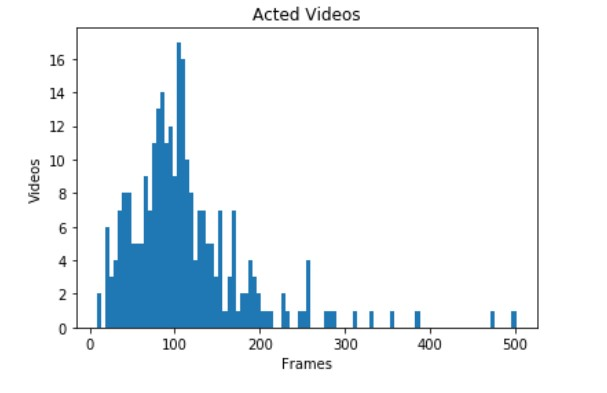

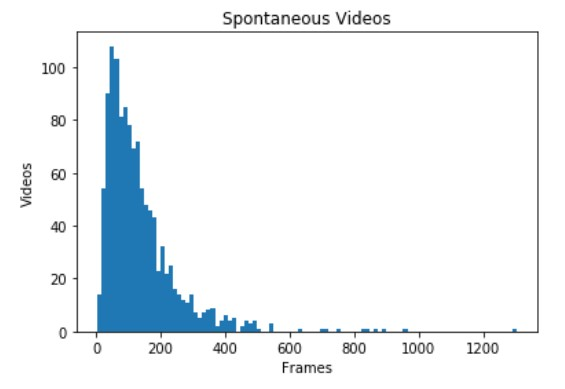

In [27]:
# frame count for functions as described
def get_frame_count(fn):
    cap = cv2.VideoCapture(fn)
    ret = True
    for i in range(10000):
        ret, _ = cap.read()
        if ret == False:
            return i

num_frames_a = []
num_frames_s = []
num_frames_s_train = []
num_frames_s_test = []

for i in range(len(caps_a)):
    num_frames_a.append(get_frame_count(caps_a[i]))
for i in range(len(caps_s)):
    num_frames_s.append(get_frame_count(caps_s[i])) 
    if flag_s[i] == True: 
        num_frames_s_train.append(get_frame_count(caps_s[i]))
    else: num_frames_s_test.append(get_frame_count(caps_s[i]))
    
    
print(max(num_frames_a))
print(max(num_frames_s))
print(min(num_frames_a))
print(min(num_frames_s))

505
962
17
9


In [28]:
# looking at train and test splits
train_emotions = []
test_emotions = []
for i in range(len(df_s)):
    if flag_s[i] == True: 
        train_emotions.append(df_s['Emotion Code'].iloc[i])  
    else: test_emotions.append(df_s['Emotion Code'].iloc[i]) 

freq_a = Counter(df_a['Emotion Code'])
freq_s = Counter(df_s['Emotion Code'])
freq_s_train = Counter(train_emotions)

# determining weights - used for weighted sampling by the generators in order to train on a balanced sample
weights_a = np.zeros(len(caps_a))
weights_s = np.zeros(len(caps_s))
weights_s_train = np.zeros(len(train_emotions))
weights_s_test = np.zeros(len(test_emotions))

for i in range(len(caps_a)):
    weights_a[i] = 1/freq_a[df_a['Emotion Code'].iloc[i]]
weights_a = weights_a / sum(weights_a)  

for i in range(len(caps_s)):
    weights_s[i] = 1/freq_s[df_s['Emotion Code'].iloc[i]]
weights_s = weights_s / sum(weights_s)  

for i in range(len(train_emotions)):
    weights_s_train[i] = 1/freq_s[train_emotions[i]]
weights_s_train = weights_s_train / sum(weights_s_train) 

for i in range(len(test_emotions)):
    weights_s_test[i] = 1/freq_s[test_emotions[i]]
weights_s_test = weights_s_test / sum(weights_s_test) 

# weights derived
print(sum(weights_a))
print(sum(weights_s))
print(sum(weights_s_train))
print(sum(weights_s_test))

1.0000000000000013
0.9999999999999996
0.9999999999999974
1.0000000000000004


In [29]:
# categorical classes for the sake of classification output
emotion_cat_a = keras.utils.to_categorical(df_a['Emotion Code'])
emotion_cat_s = keras.utils.to_categorical(df_s['Emotion Code'])
emotion_cat_s_train = keras.utils.to_categorical(train_emotions)
emotion_cat_s_test = keras.utils.to_categorical(test_emotions)

In [30]:
# generators to be used for the training
# we are training with generators because the complete data would not fit in memory

def one_frame_to_tensor(frame_ind,file,dim1,dim2,channels):
    one_frame_tensor = np.zeros((dim1,dim2,channels),dtype=int)
    cap = cv2.VideoCapture(file)
    #x = np.zeros(480, 854, 3)
    for j in range(frame_ind+1):
        _, x = cap.read()
    one_frame_tensor[:,:,0] = cv2.resize(x[:,187:667,:],(dim2,dim1))[:,:,2] / 255
    one_frame_tensor[:,:,1] = cv2.resize(x[:187:667,:],(dim2,dim1))[:,:,1] / 255
    one_frame_tensor[:,:,2] = cv2.resize(x[:,187:667,:],(dim2,dim1))[:,:,0] / 255
    return one_frame_tensor

# frame generator function to define batches
def frames_generator(caps_list,emotions_list,num_frames_list,weights_list,batch_size = 32,rand_ind=True):
    while True:
        batch_inds = np.random.choice(range(len(caps_list)),batch_size,p=weights_list)
        if rand_ind == False:
            batch_inds = np.array(range(batch_size))
        
        batch_input = []
        batch_output = []

        for ind in batch_inds:
            frame_count = num_frames_list[ind]
            frame_ind = random.sample(range(frame_count),1)[0]
            input = one_frame_to_tensor(frame_ind,caps_list[ind],224,224,3)
            output = emotions_list[ind]
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        #return batch_x, batch_y
        yield batch_x, batch_y      

# frame selection functions as necessitated by distribution of frame sizes

def vid_frame_selector(fn,frame_start,frame_count=20,frame_jump=1,dim1=128,dim2=128,channels=3):
    vid_tensor = np.zeros((frame_count,dim1,dim2,channels),dtype=int)
    cap = cv2.VideoCapture(fn)
    for i in range(frame_start):
        _, _ = cap.read()
    for i in range(frame_count):   
        for j in range(frame_jump):
            ret, x = cap.read()
            if ret == False: 
                cap = cv2.VideoCapture(fn)
                ret, x = cap.read()
        vid_tensor[i,:,:,0] = cv2.resize(x[:,187:667,:],(dim2,dim1))[:,:,2] / 255
        vid_tensor[i,:,:,1] = cv2.resize(x[:,187:667,:],(dim2,dim1))[:,:,1] / 255
        vid_tensor[i,:,:,2] = cv2.resize(x[:,187:667,:],(dim2,dim1))[:,:,0] / 255
    return vid_tensor 
 
# using random frame selection 
def frames_select_generator(caps_list,emotions_list,num_frames_list,weights_list,batch_size = 32,count=20,frame_jump=1,rand_ind=True):
    while True:

        batch_x = np.zeros((batch_size,count,128,128,3),dtype=int)
        
        batch_inds = np.random.choice(range(len(caps_list)),batch_size,p=weights_list)
        if rand_ind == False:
            batch_inds = np.array(range(batch_size))
        batch_input = []
        batch_output = []

        for i in range(len(batch_inds)):
            ind = batch_inds[i]
            frame_count = num_frames_list[ind]
            frame_ind = random.sample(range(frame_count),1)[0]
            input = vid_frame_selector(caps_list[ind],frame_ind,count,frame_jump,128,128,3)
            output = emotions_list[ind]
            batch_x[i,:,:,:,:] = input
            batch_output += [output]
        batch_y = np.array(batch_output)

        #return batch_x, batch_y
        yield batch_x, batch_y

        

### 3. Models

#### We have decided to focus on three main models: 
PART A
 1. Conv3d
 2. TimeDistributed Conv3d plus recurrent

PART B
 3. "DeepFace" based on vgg_face_weights
 
Then a summary of results: 

PART C:


    Predicted vs. Actual + Summary Results

#### PART A

#### i. Creation/compilation of Models 1 and 2

#### Model 1: C3D

C3D has been shown to be effective in video analysis tasks, with the ability to process appearance and information about motion at the same time (Fan et al. 16). (A variant also might include a linear classifier, which also performs well according to video analysis benchmarks.) Most importantly, C3D networks have shown to perform well in emotion recognition, so it is a worthy model structure to look at. 

In [31]:
# model creation/compilation
def Create_Conv3D(input_shape,classes_count):

    model = Sequential()
    model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(units=classes_count, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return(model)

In [32]:
# summarize
model1=Create_Conv3D(input_shape=(20,128,128,3),classes_count=emotion_cat_s.shape[1])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 18, 126, 126, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 63, 63, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 61, 61, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 30, 30, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 14, 28, 28, 64)    55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 14, 14, 64)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 12, 12, 64)    110656    
__________

#### Model 2: Conv 2D Time Distributed + RNN model

In the same study referenced to above, Conv2d's classification abilites have been shown to be heightened. The hybrid network with C2D and RNN has been shown to improve results for emotional classification, and thus, such hybridization is worth a simulation. (Fan et al. 16)

In [33]:
# model creation/compilation
def Create_LRCN(input_shape,classes_count):
    #lrcn - sequence length
    #https://github.com/udacity/self-driving-car/blob/master/steering-models/community-models/chauffeur/models.py
    #Heavily influenced by VGG-16:
    #https://arxiv.org/abs/1409.1556
    #https://arxiv.org/pdf/1411.4389.pdf
    #https://github.com/harvitronix/five-video-classification-methods
    model = Sequential()

    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu'), 
                              input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(SimpleRNN(units=64, return_sequences=False, dropout=0.2))
    model.add(Dense(units=classes_count, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return(model)

In [34]:
# summarize
model2=Create_LRCN(input_shape=(30,128,128,3),classes_count=emotion_cat_s.shape[1])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 63, 63, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 31, 31, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 14, 14, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 12, 12, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 6, 6, 64)      0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 4, 4, 64)      36928     
__________

#### ii. Training and plotted accuracy of Models 1 and 2

#### Model 1: Training + Accuracy Plot

In [35]:
%%time
# training Model 1
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_conv3d = model1.fit_generator(generator=frames_select_generator(caps_s_train,emotion_cat_s_train,num_frames_s_train,weights_s_train,batch_size = 32,count=20,frame_jump=3),
                                  steps_per_epoch=16,
                                  epochs=10,
                                  verbose=1, 
                                  callbacks=[early_stopping],
                                  validation_data=frames_select_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = 32,count=20,frame_jump=3),
                                  validation_steps= 8)

Epoch 1/10
16/16 [==============================] - 178s 11s/step - loss: 2.7120 - acc: 0.1250 - val_loss: 2.2115 - val_acc: 0.1953
Epoch 2/10
16/16 [==============================] - 155s 10s/step - loss: 2.1453 - acc: 0.1660 - val_loss: 2.0926 - val_acc: 0.2305
Epoch 3/10
16/16 [==============================] - 155s 10s/step - loss: 2.0488 - acc: 0.2207 - val_loss: 2.0778 - val_acc: 0.2031
Epoch 4/10
16/16 [==============================] - 156s 10s/step - loss: 2.0491 - acc: 0.2207 - val_loss: 2.0607 - val_acc: 0.2383
Epoch 5/10
16/16 [==============================] - 161s 10s/step - loss: 1.8714 - acc: 0.3164 - val_loss: 2.0027 - val_acc: 0.3008
Epoch 6/10
16/16 [==============================] - 161s 10s/step - loss: 1.6991 - acc: 0.3633 - val_loss: 2.3594 - val_acc: 0.2734
Epoch 7/10
16/16 [==============================] - 165s 10s/step - loss: 1.5948 - acc: 0.4297 - val_loss: 2.0783 - val_acc: 0.3008
Epoch 8/10
16/16 [==============================] - 160s 10s/step - loss: 1.

In [36]:
# create training plot to deem accuracy and loss
def training_plot(history, model_name):
    acc1 = history.history['acc']
    val_acc1 = history.history['val_acc']
    loss1 = history.history['loss']
    val_loss1 = history.history['val_loss']

    epochs = range(len(acc1))

    plt.plot(epochs,acc1, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy - ' + model_name)
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss1, 'bo', label='Training loss')
    plt.plot(epochs,val_loss1, 'b', label='Validation loss')
    plt.title('Training and validation loss - ' + model_name)
    plt.legend()

    plt.show()

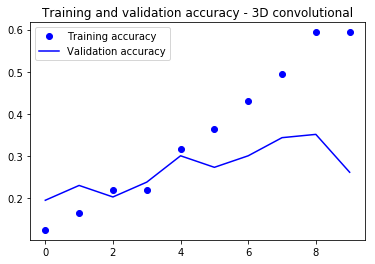

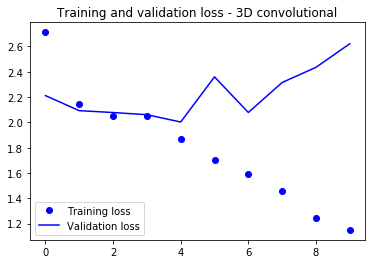

In [37]:
# outcome for Model 1
training_plot(history_conv3d,"3D convolutional")

#### Model 2: Training + Accuracy Plot

In [38]:
%%time
# training for Model 2
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_lrcn = model2.fit_generator(generator=frames_select_generator(caps_s_train,emotion_cat_s_train,num_frames_s_train,weights_s_train,batch_size = 32,count=30,frame_jump=1),
                                  steps_per_epoch=16,
                                  epochs=10,
                                  verbose=1, 
                                  callbacks=[early_stopping],
                                  validation_data=frames_select_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = 32,count=30,frame_jump=1),
                                  validation_steps= 8)

Epoch 1/10
16/16 [==============================] - 146s 9s/step - loss: 2.2490 - acc: 0.1445 - val_loss: 2.2293 - val_acc: 0.1094
Epoch 2/10
16/16 [==============================] - 128s 8s/step - loss: 2.1222 - acc: 0.1738 - val_loss: 2.1419 - val_acc: 0.1055
Epoch 3/10
16/16 [==============================] - 128s 8s/step - loss: 2.0223 - acc: 0.2070 - val_loss: 2.0970 - val_acc: 0.1758
Epoch 4/10
16/16 [==============================] - 128s 8s/step - loss: 1.9361 - acc: 0.2676 - val_loss: 2.1056 - val_acc: 0.1914
Epoch 5/10
16/16 [==============================] - 131s 8s/step - loss: 1.9388 - acc: 0.2676 - val_loss: 2.0605 - val_acc: 0.1914
Epoch 6/10
16/16 [==============================] - 129s 8s/step - loss: 1.8190 - acc: 0.3027 - val_loss: 2.1247 - val_acc: 0.2500
Epoch 7/10
16/16 [==============================] - 138s 9s/step - loss: 1.8412 - acc: 0.3027 - val_loss: 2.0379 - val_acc: 0.2773
Epoch 8/10
16/16 [==============================] - 133s 8s/step - loss: 1.7301 - a

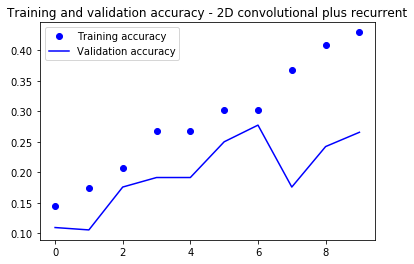

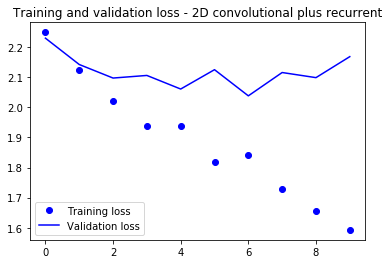

In [39]:
# outcome for Model 2
training_plot(history_lrcn,"2D convolutional plus recurrent")

#### PART B

#### i. Creation/compilation of Model 3

The Deep Face model is a very large model with 145 million trained parameters.  We have tried to extract a lightweight version of it by taking only some of the layers.

In [40]:
# create layers and define parameters for Model 3
model3 = Sequential()
model3.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2,2), strides=(2,2)))
 
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2,2), strides=(2,2)))
 
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2,2), strides=(2,2)))
 
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2,2), strides=(2,2)))
 
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2,2), strides=(2,2)))
 
model3.add(Conv2D(4096, (7, 7), activation='relu'))
model3.add(Dropout(0.5))
model3.add(Conv2D(4096, (1, 1), activation='relu'))
model3.add(Dropout(0.5))
model3.add(Conv2D(2622, (1, 1)))
model3.add(Flatten())
model3.add(Activation('softmax'))

In [41]:
# Summarize
model3.load_weights('vgg_face_weights.h5')

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [42]:
for i in range(20):
    model3.pop()

for layer in model3.layers[:-3]:
    layer.trainable = False

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [43]:
model3a = Sequential()

model3a.add(InputLayer(input_shape=(30,30,256)))
model3a.add(Flatten())
model3a.add(Dense(units=32))
model3a.add(Dropout(0.2))
model3a.add(Dense(units=emotion_cat_s.shape[1], activation='softmax'))

model3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                7372832   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 13)                429       
Total params: 7,373,261
Trainable params: 7,373,261
Non-trainable params: 0
_________________________________________________________________


In [44]:
model3b = Sequential([model3, model3a])
model3b.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model3b.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30, 30, 256)       1735488   
_________________________________________________________________
sequential_4 (Sequential)    (None, 13)                7373261   
Total params: 9,108,749
Trainable params: 7,963,341
Non-trainable params: 1,145,408
_________________________________________________________________


#### ii. Training and plotted accuracy of Models 3

In [45]:
%%time
# training Model 3
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_vgg = model3b.fit_generator(generator=frames_generator(caps_s_train,emotion_cat_s_train,num_frames_s_train,weights_s_train,batch_size = 32),
                                  steps_per_epoch=16,
                                  epochs=10,
                                  verbose=1, 
                                  callbacks=[early_stopping],
                                  validation_data=frames_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = 32),
                                  validation_steps= 8)

Epoch 1/10
16/16 [==============================] - 75s 5s/step - loss: 13.7396 - acc: 0.1426 - val_loss: 13.8515 - val_acc: 0.1406
Epoch 2/10
16/16 [==============================] - 61s 4s/step - loss: 14.4496 - acc: 0.1035 - val_loss: 13.8515 - val_acc: 0.1406
Epoch 3/10
16/16 [==============================] - 63s 4s/step - loss: 14.5441 - acc: 0.0977 - val_loss: 13.9774 - val_acc: 0.1328
Epoch 4/10
16/16 [==============================] - 62s 4s/step - loss: 13.9774 - acc: 0.1328 - val_loss: 13.4737 - val_acc: 0.1641
Epoch 5/10
16/16 [==============================] - 69s 4s/step - loss: 13.8830 - acc: 0.1387 - val_loss: 13.7250 - val_acc: 0.1484
Epoch 6/10
16/16 [==============================] - 64s 4s/step - loss: 14.2948 - acc: 0.1113 - val_loss: 13.6626 - val_acc: 0.1523
Epoch 7/10
16/16 [==============================] - 65s 4s/step - loss: 14.6070 - acc: 0.0938 - val_loss: 13.9774 - val_acc: 0.1328
Epoch 8/10
16/16 [==============================] - 65s 4s/step - loss: 14.0

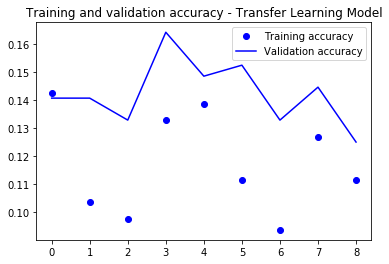

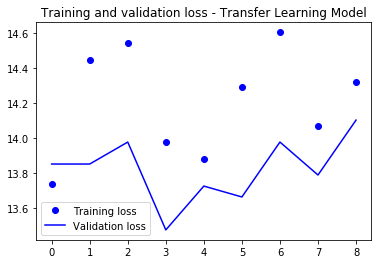

In [46]:
# accuracy outcomes for Model 3
training_plot(history_vgg,"Transfer Learning Model")

#### Part C: Predicted vs. Actual + Summary Results

In [47]:
# note: the data used here is the same as the data that was used as validation data while training
test_x1, test_y1 = next(frames_select_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = len(caps_s_test),count=20,frame_jump=3))
test_x2, test_y2 = next(frames_select_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = len(caps_s_test),count=30,frame_jump=1))
test_x3, test_y3 = next(frames_generator(caps_s_test,emotion_cat_s_test,num_frames_s_test,weights_s_test,batch_size = len(caps_s_test)))

pred1 = model1.predict(test_x1)
pred2 = model2.predict(test_x2)
pred3 = model3b.predict(test_x3)

In [48]:
y1 = np.argmax(test_y1,axis=1)
print(y1)
print(Counter(y1))

[11  1  6  4  4  8 10  8  6 12 10  4  3  8 10 11 11 10  4  8 10  1  3 10
  4  6  8 11 11  4 11  1  3  4  1 12  3  3  3  1 11  3  3  1  8  6  4  1
  1  4 12  4  3 10  3  6 12  1  1  4 10  4 10 12 11  4 12  3  3  6  3  3
  6  4  1  6 10  3  4  3 11 10 10  4 11 11  3  4  3  3  3  6 12  1  1  3
  3 12  4 11 12  4 12 12  4 10  3 10  8  8  4  1 10  3 11 11  1 10  3  4
 12  4 11 12 11  8 12 12 10  8  3 11 11 12 11  4 11 11  4  3 11 12  8  4]
Counter({3: 27, 4: 26, 11: 22, 10: 17, 12: 17, 1: 15, 8: 11, 6: 9})


In [49]:
x1 = np.argmax(pred1,axis=1)
x2 = np.argmax(pred2,axis=1)
x3 = np.argmax(pred3,axis=1)

print(x1)
print(x2)
print(x3)

[12  6 10  8  8  8  3  4  8  1 10 12 11  4 10  6 12 11 12  4  1  1 12  8
 12  6 10 11  6 12  6  6 12 12  3 11 10  8 12  1  6  1  3  1 12  6  4  1
  6 12 12  8  8 12 12  8  4 12 12 12 10 12 10 12  6 12 11 12  8  6  6 10
  6 12 12 12 11  8  3 12  6 12  1  8  6 10 10 12  8  1  8  6  3  1 12  6
  3 12 12  8 12  8 12 12  8  8  1 12  8 12  4  3 10 11  3  6  1 10  8  4
 12 12  3 11 11  8 12 12 10  8  3  6 11  8  6 12 12 10 12 11 12 12  8 12]
[11 11  4  4  4  3 12  4 10  6 10  6  8 10  4  8  1  1 10  4  6 10  1  3
 10  4  1  4 10 12  6  3 10 10  3  6 10 10  3  6  3  8  6  8  8  6  6 10
  3 10  6  6 10  4  4  8  6  6 10  4  8  6  4  6 10  3  6  4  4 10  4  3
 11 11  1  3  3 10 12  1 10  6  8  8  3  3  6  6  8  6  4 11  6  8  4  1
 10  4  8  1 10  1  1 10  8  6 11  8 10  4 10  1 10  1  8  4  6 11  3  4
  4  3  4  6 10  4  4  1 10  6  4 10 12  8  3 10  8 12 12 10 10  4  8  6]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [50]:
print("Conv3D - Predicted versus actual")
print(pd.crosstab(np.argmax(test_y1,axis=1),np.argmax(pred1,axis=1)))

Conv3D - Predicted versus actual
col_0  1   3   4   6   8   10  11  12
row_0                                
1       6   2   0   3   0   0   0   4
3       3   3   0   2   7   3   3   6
4       0   1   3   0   6   0   0  16
6       0   0   0   5   2   1   0   1
8       0   0   3   0   5   1   0   2
10      2   1   0   0   2   7   2   3
11      0   2   0  10   1   2   3   4
12      1   1   1   0   1   0   3  10


In [51]:
print("Conv2D + Recurrent - Predicted versus actual")
print(pd.crosstab(np.argmax(test_y2,axis=1),np.argmax(pred2,axis=1)))

Conv2D + Recurrent - Predicted versus actual
col_0  1   3   4   6   8   10  11  12
row_0                                
1       5   1   1   3   0   9   0   0
3       1   6   1   4   2  10   3   0
4       2   3  13   4   0   1   0   0
6       1   0   0   5   1   1   1   0
8       0   3   2   2   8   0   2   2
10      2   1   1   3   0   3   0   1
11      2   0   0   4   6   5   1   0
12      0   2   9   1   1   2   0   3


In [52]:
print("Transfer Learning - Predicted versus actual")
print(pd.crosstab(np.argmax(test_y3,axis=1),np.argmax(pred3,axis=1)))

Transfer Learning - Predicted versus actual
col_0   1
row_0    
1      19
3      18
4      26
6      16
8      15
10     14
11     18
12     18


### Overall Results Summary: 
 - Part A: Of the 144 videos in the test dataset, Model 1 correctly predicted 42 of them (29%). Model 2 correctly predicted 44 (31%).  These stats are better than what is reported by Keras during training, as they haven't gone through the sample rebalancing. 
 
- Part B: On the other hand, we see that Model 3 tends to misclassify, only classifying to one emotion despite variability of input. We haven't succeeded in setting up a model structure that works with the pretrained model weights to get a useful prediction.  Building a workable transfer learning model for faces that can fit within our computing resources turned out to be a difficult task.

### 4. Conclusions/Lessons Learned

In the EmotiW contestants' papers of finalists, we observed 50-60% accuracy, and we have achieved about 30% accuracy for our own models, a comparable achievement given the time constraints and the learning curve of having to deal with the complexities of a non-standardized and large video dataset. We were able to detect emotions with relative levels of accuracy, and have learned many lessons along the way.

Note that for Model 3, we continually had misclassification issues. We had similar issues with the first two models, before troubleshooting and realizing that we had not scaled the data. Upon further examinations we realized the importance of this normalization. Without scaling input training vectors,the distribution range of feature values would differ for each feature, allowing the learning rate to create variable dimensional corrections, creating problematic differential compensations across inputs. This issue might prove to be problematic with the backpropagation of CNN's especially. Thus, we added these scaling methods and were able to produce the statistics we reported. However, if we had realized the challenge of working with VGG Face for our purposes earlier, we would have spent more time in trying to troubleshoot this issue in order to learn how to achieve such a tranfer learning model within our computing capacitites. Alternatively, we could and should have tested comparable methods to VGG Face to figure out whether this was a VGG specific issue we were facing. These obstacles were definitely a lesson worth learning in dealing with hefty and rich data sets and properly strategizing and reappropriating tools like VGGFace given a probable learning curve. Thus future models would 1) further tune hyperparameters of the first two model structures that functioned properly 2) work more effectively with structures like VGGFace and 3) test out more types of hybridized models (ex. combining a CNN with other RNN's we explored in class).

Tasks involved in this project that we had not done before are :
- extracting data from video files and setting relevant benchmarks
- implemetning creative hybridization of models specific to such data
- working with VGG Face

Emotion classification from video data is a fairly new frontier in machine learning, where not much is yet known about what works the best. We have experimented in this area and learned about the challenges involved, an relatively successful effective endeavor.  The high dimensionality of the data was a big challenge given our available computing resources.  We dealt with that by training video frames resized to a smaller size and by feeding the training with a generator, although this adds to the training time required.  The model setup we have in place runs up against the memory capacity limits of JupyterHub. Moreover, we played around with different hybridized model structures, drawing off the success of such approaches we'd observed during our literature review. Although only two out of our three models performed decently, we still took away many important lessons. 




### IGNITE PRESENTATION LINK:
    
    https://docs.google.com/presentation/d/1HUtP_AxbLpatD2SBbrkN2y2s5OdI9pHcyZRGOeLWA_k/edit#slide=id.p

References: 

http://cs-people.bu.edu/sbargal/ICMI16.pdf

https://dl.acm.org/citation.cfm?id=3138923

https://ieeexplore.ieee.org/abstract/document/7961731/

https://dl.acm.org/citation.cfm?id=2997632

https://www.researchgate.net/publication/320884600_Group-level_emotion_recognition_using_transfer_learning_from_face_identification